### inputing tickers and basic setup 

In [1]:
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

# Define the tickers for the eight stocks
tickers = ['NVDA', 'GM', 'UAL', 'DIS','PEP','JPM', 'AMZN']

# Download historical data for the period 2019-2021
data = yf.download(tickers, start='2019-01-01', end='2021-07-01')['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Define the risk-free rate (annualized)
risk_free_rate = 0.03

# Annualize the mean returns and covariance matrix
trading_days = 252
annualized_returns = returns.mean() * trading_days
annualized_cov_matrix = returns.cov() * trading_days

# Include the risk-free asset in the returns and covariance matrix
annualized_returns_with_rf = np.append(annualized_returns, risk_free_rate)
annualized_cov_matrix_with_rf = np.zeros((len(tickers) + 1, len(tickers) + 1))
annualized_cov_matrix_with_rf[:-1, :-1] = annualized_cov_matrix

[*********************100%%**********************]  7 of 7 completed


### define the function for portfolio optimization

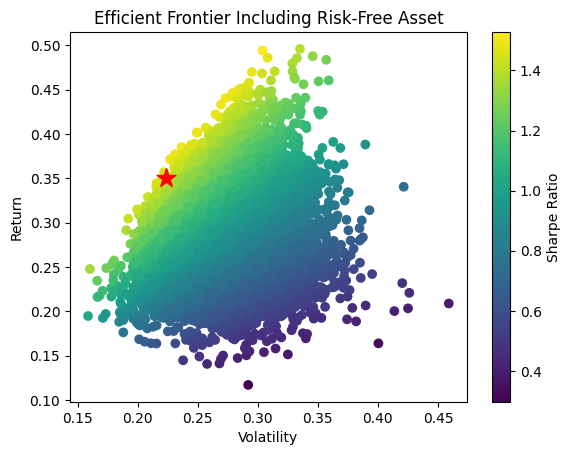

  NVDA: 0.2000
  GM: 0.0907
  UAL: 0.1060
  DIS: 0.0571
  PEP: 0.2000
  JPM: 0.1463
  AMZN: 0.0000
  Risk-Free Asset: 0.2000
Max Sharpe Ratio Return with Risk-Free Asset: 0.3503200573162749
Max Sharpe Ratio Volatility with Risk-Free Asset: 0.2235371054817212


In [2]:
# Define the objective function for maximizing Sharpe ratio, including the risk-free asset
def sharpe_ratio_with_rf(weights):
    portfolio_return = np.dot(weights, annualized_returns_with_rf)
    portfolio_volatility = np.sqrt(np.dot(weights[:-1].T, np.dot(annualized_cov_matrix_with_rf[:-1, :-1], weights[:-1])))
    return -((portfolio_return - risk_free_rate) / portfolio_volatility)  # Negative for minimization

# Constraints: Weights must sum to 1, no single security can exceed 30%, and risk-free asset between 10% and 30%
constraints_with_rf = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                       {'type': 'ineq', 'fun': lambda x: 0.30 - np.max(x[:-1])},
                       {'type': 'ineq', 'fun': lambda x: x[-1] - 0.10},  # RF weight must be at least 10%
                       {'type': 'ineq', 'fun': lambda x: 0.30 - x[-1]}]  # RF weight must not exceed 30%

# Bounds for each weight (0 <= weight <= 0.20 for stocks, 0.10 <= weight <= 0.30 for the risk-free asset)
bounds_with_rf = [(0, 0.20) for _ in range(len(tickers))] + [(0.10, 0.20)]

# Initial guess for weights (evenly distributed among stocks, and a portion for the risk-free asset)
initial_weights_with_rf = np.append([1/len(tickers)] * len(tickers), 0.1)

# Optimize the portfolio to maximize the Sharpe ratio, including the risk-free asset
result_with_rf = minimize(sharpe_ratio_with_rf, initial_weights_with_rf, method='SLSQP', bounds=bounds_with_rf, constraints=constraints_with_rf)

# Extract the optimal weights including the risk-free asset
optimal_weights_with_rf = result_with_rf.x

# Calculate the maximum Sharpe ratio return and volatility with the risk-free asset
max_sharpe_return_with_rf = np.dot(optimal_weights_with_rf, annualized_returns_with_rf)
max_sharpe_volatility_with_rf = np.sqrt(np.dot(optimal_weights_with_rf[:-1].T, np.dot(annualized_cov_matrix_with_rf[:-1, :-1], optimal_weights_with_rf[:-1])))

# Plot the efficient frontier (generated during simulation)
results = np.zeros((4, 10000))  # Update number of portfolios as desired
weights_record = []

for i in range(10000):  # Update number of portfolios as desired
    weights = np.random.random(len(tickers) + 1)
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_return = np.dot(weights, annualized_returns_with_rf)
    portfolio_volatility = np.sqrt(np.dot(weights[:-1].T, np.dot(annualized_cov_matrix_with_rf[:-1, :-1], weights[:-1])))
    sharpe_ratio_value = (portfolio_return - risk_free_rate) / portfolio_volatility
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio_value
    results[3, i] = i

plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier Including Risk-Free Asset')
plt.colorbar(label='Sharpe Ratio')

# Highlight the portfolio with the highest Sharpe ratio
plt.scatter(max_sharpe_volatility_with_rf, max_sharpe_return_with_rf, c='red', marker='*', s=200)
plt.show()

# Display the optimal weights including the risk-free asset

for i, ticker in enumerate(tickers + ['Risk-Free Asset']):
    print(f"  {ticker}: {optimal_weights_with_rf[i]:.4f}")
print("Max Sharpe Ratio Return with Risk-Free Asset:", max_sharpe_return_with_rf)
print("Max Sharpe Ratio Volatility with Risk-Free Asset:", max_sharpe_volatility_with_rf)

# Calculate portfolio returns
portfolio_returns_with_rf = returns.dot(optimal_weights_with_rf[:-1]) + optimal_weights_with_rf[-1] * risk_free_rate / trading_days

# Define a rolling window size
window_size = 252  # 1 year of trading days
alpha = 0.01

### Calculate the VaR using different methods 

In [3]:



# Initialize DataFrames to store VaR estimates
Risk_VaR = pd.DataFrame(index=returns.index[window_size:], columns=[
    'Historical', 'Variance-Covariance', 'Monte Carlo', 
    'No Correlation', 'Perfect Correlation', 
    'Gaussian Copulas', 't-Copula'
])

# Define a function to simulate Gumbel Copula
def simulate_gumbel_copula(n, d, theta):
    U = np.random.uniform(size=(n, d))
    W = np.random.uniform(size=(n, 1))
    V = (-np.log(U))**theta
    sum_V = np.sum(V, axis=1, keepdims=True)
    G = np.exp(-sum_V**(1/theta))
    return G * (V / sum_V)**(1/theta)

for i in range(window_size, len(portfolio_returns_with_rf)):
    # Data within the window
    X = portfolio_returns_with_rf.iloc[i-window_size:i]

    # Historical VaR
    Risk_VaR['Historical'].iloc[i-window_size] = -np.percentile(X, alpha * 100)

    # Variance-Covariance VaR
    mu, sigma = X.mean(), X.std()
    z = norm.ppf(1 - alpha)
    Risk_VaR['Variance-Covariance'].iloc[i-window_size] = z * sigma

    # Monte Carlo VaR
    simulated_returns = np.random.normal(mu, sigma, 10000)
    Risk_VaR['Monte Carlo'].iloc[i-window_size] = -np.percentile(simulated_returns, alpha * 100)

    # No Correlation VaR
    weights_var = optimal_weights_with_rf[:-1]**2
    no_corr_var = np.sqrt(np.dot(weights_var, returns.var()))
    Risk_VaR['No Correlation'].iloc[i-window_size] = z * no_corr_var

    # Perfect Correlation VaR
    weights_std = optimal_weights_with_rf[:-1] * returns.std()
    perfect_corr_var = np.sum(weights_std)
    Risk_VaR['Perfect Correlation'].iloc[i-window_size] = z * perfect_corr_var

    # Gaussian Copulas VaR
    u_marginals = returns.rank(axis=0) / (len(returns) + 1)
    correlation_matrix = np.corrcoef(u_marginals.T)
    cholesky_decomp = np.linalg.cholesky(correlation_matrix)
    standard_normal_random_vars = np.random.normal(size=(10000, len(tickers)))
    correlated_random_vars = standard_normal_random_vars @ cholesky_decomp.T
    uniform_random_vars = norm.cdf(correlated_random_vars)
    simulated_returns_copula = np.zeros_like(uniform_random_vars)
    for j, ticker in enumerate(tickers):
        sorted_returns = np.sort(returns[ticker])
        simulated_returns_copula[:, j] = np.percentile(sorted_returns, uniform_random_vars[:, j] * 100)
    portfolio_returns_simulated = simulated_returns_copula.dot(optimal_weights_with_rf[:-1])
    Risk_VaR['Gaussian Copulas'].iloc[i-window_size] = -np.percentile(portfolio_returns_simulated, alpha * 100)

    # t-Copula VaR
    params_t = [t.fit(returns[col]) for col in returns.columns]
    u_marginals_t = np.array([t.cdf(returns[col], *params_t[i]) for i, col in enumerate(returns.columns)]).T
    correlation_matrix_t = np.corrcoef(u_marginals_t.T)
    cholesky_matrix_t = np.linalg.cholesky(correlation_matrix_t)
    t_copula_data = np.dot(cholesky_matrix_t, np.random.standard_t(3, size=(len(tickers), 10000)))
    u_copula_simulated_t = t.cdf(t_copula_data.T, df=3)
    simulated_returns_t_copula = np.array([t.ppf(u_copula_simulated_t[:, j], *params_t[j]) for j in range(len(tickers))]).T
    portfolio_returns_simulated_t_copula = simulated_returns_t_copula.dot(optimal_weights_with_rf[:-1])
    Risk_VaR['t-Copula'].iloc[i-window_size] = -np.percentile(portfolio_returns_simulated_t_copula, alpha * 100)


# Print the VaR for each method with a window size of 252 days
print("VaR for each method (window size of 252 days):")
print(f"Historical VaR: {Risk_VaR['Historical'].iloc[-1]:.4f}")
print(f"Variance-Covariance VaR: {Risk_VaR['Variance-Covariance'].iloc[-1]:.4f}")
print(f"Monte Carlo VaR: {Risk_VaR['Monte Carlo'].iloc[-1]:.4f}")
print(f"No Correlation VaR: {Risk_VaR['No Correlation'].iloc[-1]:.4f}")
print(f"Perfect Correlation VaR: {Risk_VaR['Perfect Correlation'].iloc[-1]:.4f}")
print(f"Gaussian Copulas VaR: {Risk_VaR['Gaussian Copulas'].iloc[-1]:.4f}")
print(f"t-Copula VaR: {Risk_VaR['t-Copula'].iloc[-1]:.4f}")






VaR for each method (window size of 252 days):
Historical VaR: 0.0297
Variance-Covariance VaR: 0.0238
Monte Carlo VaR: 0.0221
No Correlation VaR: 0.0199
Perfect Correlation VaR: 0.0436
Gaussian Copulas VaR: 0.0345
t-Copula VaR: 0.0326


In [4]:
### Incremental and Marginal VaR

In [20]:
import numpy as np
from scipy.stats import norm

# Define a small change in weight (epsilon)
epsilon = 1e-4

# Initialize an array to store Marginal VaR
marginal_var = np.zeros(len(tickers) + 1)  # Include the risk-free asset

# Function to calculate portfolio VaR using Gaussian Copula given a set of weights
def calculate_portfolio_var_gaussian_copula(weights):
    u_marginals = returns.iloc[:window_size].rank(axis=0) / (len(returns.iloc[:window_size]) + 1)
    correlation_matrix = np.corrcoef(u_marginals.T)
    cholesky_decomp = np.linalg.cholesky(correlation_matrix)

    standard_normal_random_vars = np.random.normal(size=(10000, len(tickers)))
    correlated_random_vars = standard_normal_random_vars @ cholesky_decomp.T
    uniform_random_vars = norm.cdf(correlated_random_vars)

    simulated_returns_copula = np.zeros_like(uniform_random_vars)
    for j, ticker in enumerate(tickers):
        sorted_returns = np.sort(returns[ticker].iloc[:window_size])
        simulated_returns_copula[:, j] = np.percentile(sorted_returns, uniform_random_vars[:, j] * 100)

    portfolio_returns_simulated = simulated_returns_copula.dot(weights[:-1])
    portfolio_var = -np.percentile(portfolio_returns_simulated, alpha * 100)
    return portfolio_var

# Calculate the original portfolio VaR using Gaussian Copula
original_var = calculate_portfolio_var_gaussian_copula(optimal_weights_with_rf)

# Loop over each asset to calculate its Marginal VaR
for i in range(len(tickers)):  # Only iterate over risky assets
    # Create a copy of the original weights
    perturbed_weights = np.copy(optimal_weights_with_rf)
    # Increase the weight of asset i by epsilon
    perturbed_weights[i] += epsilon
    # Normalize the weights without changing the risk-free asset's weight
    perturbed_weights[:-1] /= perturbed_weights[:-1].sum() + perturbed_weights[-1]
    # Calculate the new portfolio VaR with perturbed weights
    new_var = calculate_portfolio_var_gaussian_copula(perturbed_weights)
    # Calculate Marginal VaR
    marginal_var[i] = (new_var - original_var) / epsilon

# Output Marginal VaR for each asset
for i, ticker in enumerate(tickers):
    print(f"Marginal VaR for {ticker}: {marginal_var[i]}")
print()

# Define a finite change in weight (e.g., 1% of the portfolio)
increment = 0.01

# Initialize an array to store Incremental VaR
incremental_var = np.zeros(len(tickers) + 1)  # Include the risk-free asset

# Loop over each asset to calculate its Incremental VaR
for i in range(len(tickers)):  # Only iterate over risky assets
    # Create a copy of the original weights
    perturbed_weights = np.copy(optimal_weights_with_rf)
    # Increase the weight of asset i by a finite increment
    perturbed_weights[i] += increment
    # Normalize the weights without changing the risk-free asset's weight
    perturbed_weights[:-1] /= perturbed_weights[:-1].sum() + perturbed_weights[-1]
    # Calculate the new portfolio VaR with perturbed weights
    new_var = calculate_portfolio_var_gaussian_copula(perturbed_weights)
    # Calculate Incremental VaR
    incremental_var[i] = new_var - original_var

# Output Incremental VaR for each asset
for i, ticker in enumerate(tickers):
    print(f"Incremental VaR for {ticker}: {incremental_var[i]}")
print()

Marginal VaR for NVDA: -1.880845628430411
Marginal VaR for GM: -16.969600855066755
Marginal VaR for UAL: -10.64922683605196
Marginal VaR for DIS: -11.858673837685622
Marginal VaR for PEP: -9.393101417825914
Marginal VaR for JPM: -10.043738954995142
Marginal VaR for AMZN: -5.2964501152995975

Incremental VaR for NVDA: -0.0006195936890007123
Incremental VaR for GM: -0.0002590175743640462
Incremental VaR for UAL: -0.0007402459486339566
Incremental VaR for DIS: -0.001435761662340749
Incremental VaR for PEP: -0.0013546106231666633
Incremental VaR for JPM: -0.0016651551231086324
Incremental VaR for AMZN: -0.0014471819649851739



In [6]:
## Backtest 

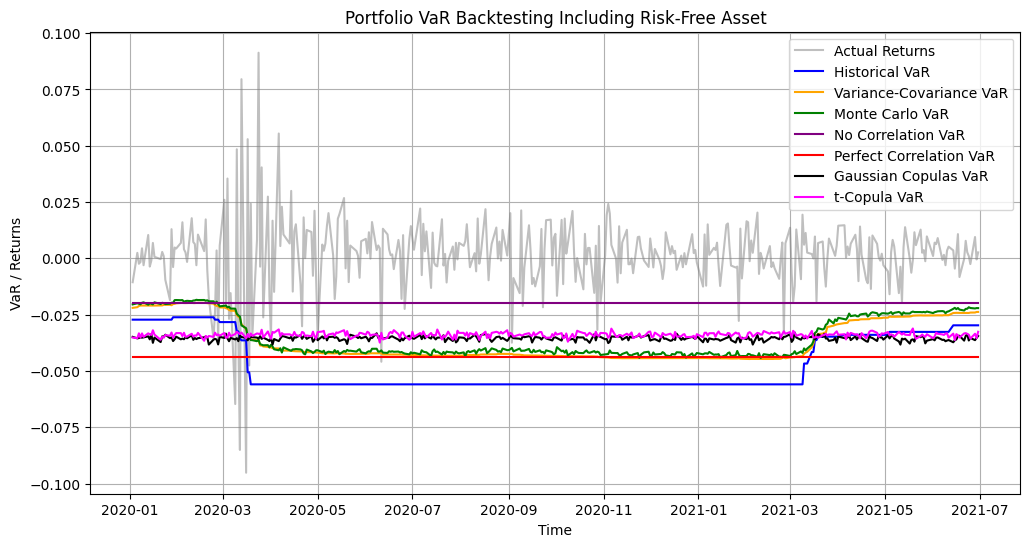

In [7]:
# Plotting the VaR calculations for the portfolio along with actual returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns_with_rf.index[window_size:], portfolio_returns_with_rf[window_size:], label='Actual Returns', color='grey', alpha=0.5)
plt.plot(Risk_VaR.index, -Risk_VaR['Historical'], label='Historical VaR', color='blue')
plt.plot(Risk_VaR.index, -Risk_VaR['Variance-Covariance'], label='Variance-Covariance VaR', color='orange')
plt.plot(Risk_VaR.index, -Risk_VaR['Monte Carlo'], label='Monte Carlo VaR', color='green')
plt.plot(Risk_VaR.index, -Risk_VaR['No Correlation'], label='No Correlation VaR', color='purple')
plt.plot(Risk_VaR.index, -Risk_VaR['Perfect Correlation'], label='Perfect Correlation VaR', color='red')
plt.plot(Risk_VaR.index, -Risk_VaR['Gaussian Copulas'], label='Gaussian Copulas VaR', color='black')
plt.plot(Risk_VaR.index, -Risk_VaR['t-Copula'], label='t-Copula VaR', color='magenta')


plt.xlabel('Time')
plt.ylabel('VaR / Returns')
plt.title('Portfolio VaR Backtesting Including Risk-Free Asset')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
### Kupiec and christoffensen test for backtest

In [9]:
from scipy import stats

# Calculate violations for each VaR method
violations_historical = (portfolio_returns_with_rf[window_size:] < -Risk_VaR['Historical']).astype(int)
violations_var_cov = (portfolio_returns_with_rf[window_size:] < -Risk_VaR['Variance-Covariance']).astype(int)
violations_monte_carlo = (portfolio_returns_with_rf[window_size:] < -Risk_VaR['Monte Carlo']).astype(int)
violations_no_corr = (portfolio_returns_with_rf[window_size:] < -Risk_VaR['No Correlation']).astype(int)
violations_perfect_corr = (portfolio_returns_with_rf[window_size:] < -Risk_VaR['Perfect Correlation']).astype(int)
violations_gaussian_copulas = (portfolio_returns_with_rf[window_size:] < -Risk_VaR['Gaussian Copulas']).astype(int)
violations_t_copula = (portfolio_returns_with_rf[window_size:] < -Risk_VaR['t-Copula']).astype(int)



In [10]:
# Function to perform both Kupiec and Christoffersen tests
def perform_tests(violations, alpha):
    # Kupiec Test
    n = len(violations)
    x = sum(violations)
    pi = alpha
    p_hat = x / n
    LR_pof = -2 * np.log(((1 - pi) ** (n - x) * pi ** x) / ((1 - p_hat) ** (n - x) * p_hat ** x))
    p_value_pof = 1 - stats.chi2.cdf(LR_pof, 1)

    # Christoffersen Test
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(violations)):
        if violations[i-1] == 0 and violations[i] == 0:
            n00 += 1
        elif violations[i-1] == 0 and violations[i] == 1:
            n01 += 1
        elif violations[i-1] == 1 and violations[i] == 0:
            n10 += 1
        elif violations[i-1] == 1 and violations[i] == 1:
            n11 += 1

    p = (n01 + n11) / (n00 + n01 + n10 + n11)

    # Check for division by zero situations
    if n00 + n01 == 0 or n10 + n11 == 0 or p == 0:
        p0 = p1 = LR_ind = p_value_ind = "Unable to calculate"
    else:
        p0 = n01 / (n00 + n01)
        p1 = n11 / (n10 + n11)
        LR_ind = -2 * np.log(((1 - p) ** (n00 + n10) * p ** (n01 + n11)) / ((1 - p0) ** n00 * p0 ** n01 * (1 - p1) ** n10 * p1 ** n11))
        p_value_ind = 1 - stats.chi2.cdf(LR_ind, 1)

    return LR_pof, p_value_pof, LR_ind, p_value_ind

# Define alpha
alpha = 0.01

# Perform tests for each method
tests_results = {}
tests_results['Historical'] = perform_tests(violations_historical, alpha)
tests_results['Variance-Covariance'] = perform_tests(violations_var_cov, alpha)
tests_results['Monte Carlo'] = perform_tests(violations_monte_carlo, alpha)
tests_results['No Correlation'] = perform_tests(violations_no_corr, alpha)
tests_results['Perfect Correlation'] = perform_tests(violations_perfect_corr, alpha)
tests_results['Gaussian Copulas'] = perform_tests(violations_gaussian_copulas, alpha)
tests_results['t-Copula'] = perform_tests(violations_t_copula, alpha)


# Print the test results
for method, result in tests_results.items():
    print(f"{method} - Kupiec Test: LR = {result[0]:.2f}, p-value = {result[1]:.4f}")
    if isinstance(result[2], str):  # Unable to calculate case
        print(f"{method} - Christoffersen Test: {result[2]}\n")
    else:
        print(f"{method} - Christoffersen Test: LR = {result[2]:.2f}, p-value = {result[3]:.4f}\n")

Historical - Kupiec Test: LR = 1.14, p-value = 0.2853
Historical - Christoffersen Test: LR = 3.17, p-value = 0.0749

Variance-Covariance - Kupiec Test: LR = 9.28, p-value = 0.0023
Variance-Covariance - Christoffersen Test: LR = 4.51, p-value = 0.0337

Monte Carlo - Kupiec Test: LR = 9.28, p-value = 0.0023
Monte Carlo - Christoffersen Test: LR = 4.51, p-value = 0.0337

No Correlation - Kupiec Test: LR = 49.62, p-value = 0.0000
No Correlation - Christoffersen Test: LR = 0.15, p-value = 0.7006

Perfect Correlation - Kupiec Test: LR = 0.37, p-value = 0.5407
Perfect Correlation - Christoffersen Test: LR = 0.14, p-value = 0.7132

Gaussian Copulas - Kupiec Test: LR = 1.14, p-value = 0.2853
Gaussian Copulas - Christoffersen Test: LR = 0.20, p-value = 0.6587

t-Copula - Kupiec Test: LR = 9.28, p-value = 0.0023
t-Copula - Christoffersen Test: LR = 1.00, p-value = 0.3181



In [11]:
### MSE and MAE 

In [12]:
# Initialize lists to store errors for MSE and MAE calculation
errors_historical = []
errors_var_cov = []
errors_monte_carlo = []
errors_no_corr = []
errors_perfect_corr = []
errors_gaussian_copulas = []
errors_t_copula = []


for i in range(len(portfolio_returns_with_rf[window_size:])):
    actual_return = portfolio_returns_with_rf.iloc[window_size + i]

    try:
        # Historical VaR
        var_historical = Risk_VaR['Historical'].iloc[i]
        if not np.isnan(var_historical) and actual_return < var_historical:
            errors_historical.append(var_historical - actual_return)

        # Variance-Covariance VaR
        var_var_cov = Risk_VaR['Variance-Covariance'].iloc[i]
        if not np.isnan(var_var_cov) and actual_return < var_var_cov:
            errors_var_cov.append(var_var_cov - actual_return)

        # Monte Carlo VaR
        var_monte_carlo = Risk_VaR['Monte Carlo'].iloc[i]
        if not np.isnan(var_monte_carlo) and actual_return < var_monte_carlo:
            errors_monte_carlo.append(var_monte_carlo - actual_return)

        # No Correlation VaR
        var_no_corr = Risk_VaR['No Correlation'].iloc[i]
        if not np.isnan(var_no_corr) and actual_return < var_no_corr:
            errors_no_corr.append(var_no_corr - actual_return)

        # Perfect Correlation VaR
        var_perfect_corr = Risk_VaR['Perfect Correlation'].iloc[i]
        if not np.isnan(var_perfect_corr) and actual_return < var_perfect_corr:
            errors_perfect_corr.append(var_perfect_corr - actual_return)

        # Gaussian Copulas VaR
        var_gaussian_copulas = Risk_VaR['Gaussian Copulas'].iloc[i]
        if not np.isnan(var_gaussian_copulas) and actual_return < var_gaussian_copulas:
            errors_gaussian_copulas.append(var_gaussian_copulas - actual_return)

        # t-Copula VaR
        var_t_copula = Risk_VaR['t-Copula'].iloc[i]
        if not np.isnan(var_t_copula) and actual_return < var_t_copula:
            errors_t_copula.append(var_t_copula - actual_return)


    except IndexError:
        continue

# Calculate MSE and MAE for each method
def calculate_mse_mae(errors):
    mse = np.mean([e**2 for e in errors]) if errors else np.nan
    mae = np.mean([abs(e) for e in errors]) if errors else np.nan
    return mse, mae

mse_historical, mae_historical = calculate_mse_mae(errors_historical)
mse_var_cov, mae_var_cov = calculate_mse_mae(errors_var_cov)
mse_monte_carlo, mae_monte_carlo = calculate_mse_mae(errors_monte_carlo)
mse_no_corr, mae_no_corr = calculate_mse_mae(errors_no_corr)
mse_perfect_corr, mae_perfect_corr = calculate_mse_mae(errors_perfect_corr)
mse_gaussian_copulas, mae_gaussian_copulas = calculate_mse_mae(errors_gaussian_copulas)
mse_t_copula, mae_t_copula = calculate_mse_mae(errors_t_copula)


# Print the results
print("MSE and MAE for each VaR method:")
print(f"Historical VaR: MSE = {mse_historical}, MAE = {mae_historical}")
print(f"Variance-Covariance VaR: MSE = {mse_var_cov}, MAE = {mae_var_cov}")
print(f"Monte Carlo VaR: MSE = {mse_monte_carlo}, MAE = {mae_monte_carlo}")
print(f"No Correlation VaR: MSE = {mse_no_corr}, MAE = {mae_no_corr}")
print(f"Perfect Correlation VaR: MSE = {mse_perfect_corr}, MAE = {mae_perfect_corr}")
print(f"Gaussian Copulas VaR: MSE = {mse_gaussian_copulas}, MAE = {mae_gaussian_copulas}")
print(f"t-Copula VaR: MSE = {mse_t_copula}, MAE = {mae_t_copula}")



MSE and MAE for each VaR method:
Historical VaR: MSE = 0.002516510117389049, MAE = 0.046851677332399644
Variance-Covariance VaR: MSE = 0.0015989215632903379, MAE = 0.036627283772429575
Monte Carlo VaR: MSE = 0.0014973304105775547, MAE = 0.03520268591985014
No Correlation VaR: MSE = 0.0006108421657712211, MAE = 0.02043240511587641
Perfect Correlation VaR: MSE = 0.0020611748133028086, MAE = 0.042968222278349226
Gaussian Copulas VaR: MSE = 0.0014329510581892262, MAE = 0.03493335571961345
t-Copula VaR: MSE = 0.0013302523906972247, MAE = 0.033458647399065226


In [13]:
### violation rate 

In [14]:

# Initialize variables to count violations for each VaR method
violations_historical = 0
violations_var_cov = 0
violations_monte_carlo = 0
violations_no_corr = 0
violations_perfect_corr = 0
violations_gaussian_copulas = 0
violations_t_copula = 0



max_observations = min(len(Risk_VaR), len(portfolio_returns_with_rf) - window_size)

for i in range(len(portfolio_returns_with_rf[window_size:])):
    actual_return = portfolio_returns_with_rf.iloc[window_size + i]

    # Check for violations for each method
    if actual_return < -Risk_VaR['Historical'].iloc[i]:
        violations_historical += 1
    if actual_return < -Risk_VaR['Variance-Covariance'].iloc[i]:
        violations_var_cov += 1
    if actual_return < -Risk_VaR['Monte Carlo'].iloc[i]:
        violations_monte_carlo += 1
    if actual_return < -Risk_VaR['No Correlation'].iloc[i]:
        violations_no_corr += 1
    if actual_return < -Risk_VaR['Perfect Correlation'].iloc[i]:
        violations_perfect_corr += 1
    if actual_return < -Risk_VaR['Gaussian Copulas'].iloc[i]:
        violations_gaussian_copulas += 1
    if actual_return < -Risk_VaR['t-Copula'].iloc[i]:
        violations_t_copula += 1


# Calculate violation rates based on the actual number of observations
violation_rate_historical = violations_historical / max_observations
violation_rate_var_cov = violations_var_cov / max_observations
violation_rate_monte_carlo = violations_monte_carlo / max_observations
violation_rate_no_corr = violations_no_corr / max_observations
violation_rate_perfect_corr = violations_perfect_corr / max_observations
violation_rate_gaussian_copulas = violations_gaussian_copulas / max_observations
violation_rate_t_copula = violations_t_copula / max_observations


# Print violation rates
print("Violation Rates for each VaR method:")
print(f"Historical VaR: Violation Rate = {violation_rate_historical:.4f}")
print(f"Variance-Covariance VaR: Violation Rate = {violation_rate_var_cov:.4f}")
print(f"Monte Carlo VaR: Violation Rate = {violation_rate_monte_carlo:.4f}")
print(f"No Correlation VaR: Violation Rate = {violation_rate_no_corr:.4f}")
print(f"Perfect Correlation VaR: Violation Rate = {violation_rate_perfect_corr:.4f}")
print(f"Gaussian Copulas VaR: Violation Rate = {violation_rate_gaussian_copulas:.4f}")
print(f"t-Copula VaR: Violation Rate = {violation_rate_t_copula:.4f}")


Violation Rates for each VaR method:
Historical VaR: Violation Rate = 0.0160
Variance-Covariance VaR: Violation Rate = 0.0293
Monte Carlo VaR: Violation Rate = 0.0293
No Correlation VaR: Violation Rate = 0.0638
Perfect Correlation VaR: Violation Rate = 0.0133
Gaussian Copulas VaR: Violation Rate = 0.0160
t-Copula VaR: Violation Rate = 0.0293


In [15]:
### Method Comparison

In [16]:
# Define a function to calculate the ranks and select the best VaR method
def select_best_var_method(errors_dict, violation_rates_dict, kupiec_results_dict, christoffersen_results_dict):
    # Initialize a DataFrame to store ranks
    ranks = pd.DataFrame(index=errors_dict.keys(), columns=['MSE', 'MAE', 'Violation Rate', 'Kupiec Test', 'Christoffersen Test'])

    # Rank by MSE
    mse_values = {method: errors[0] for method, errors in errors_dict.items()}
    ranks['MSE'] = pd.Series(mse_values).rank()

    # Rank by MAE
    mae_values = {method: errors[1] for method, errors in errors_dict.items()}
    ranks['MAE'] = pd.Series(mae_values).rank()

    # Rank by Violation Rate
    ranks['Violation Rate'] = pd.Series(violation_rates_dict).rank()

    # Rank by Kupiec Test p-value (higher is better)
    kupiec_pvalues = {method: result[1] for method, result in kupiec_results_dict.items()}
    ranks['Kupiec Test'] = pd.Series(kupiec_pvalues).rank(ascending=False)

    # Rank by Christoffersen Test p-value (higher is better)
    christoffersen_pvalues = {method: result[3] for method, result in christoffersen_results_dict.items()}
    ranks['Christoffersen Test'] = pd.Series(christoffersen_pvalues).rank(ascending=False)

    # Calculate average rank
    ranks['Average Rank'] = ranks.mean(axis=1)

    # Select the best method based on the lowest average rank
    best_method = ranks['Average Rank'].idxmin()

    return best_method, ranks

# Assume we have calculated the errors, violation rates, and test results for all methods
errors_dict = {
    'Historical': (mse_historical, mae_historical),
    'Variance-Covariance': (mse_var_cov, mae_var_cov),
    'Monte Carlo': (mse_monte_carlo, mae_monte_carlo),
    'No Correlation': (mse_no_corr, mae_no_corr),
    'Perfect Correlation': (mse_perfect_corr, mae_perfect_corr),
    'Gaussian Copulas': (mse_gaussian_copulas, mae_gaussian_copulas),
    't-Copula': (mse_t_copula, mae_t_copula)

}

violation_rates_dict = {
    'Historical': violation_rate_historical,
    'Variance-Covariance': violation_rate_var_cov,
    'Monte Carlo': violation_rate_monte_carlo,
    'No Correlation': violation_rate_no_corr,
    'Perfect Correlation': violation_rate_perfect_corr,
    'Gaussian Copulas': violation_rate_gaussian_copulas,
    't-Copula': violation_rate_t_copula

}

kupiec_results_dict = {
    'Historical': tests_results['Historical'],
    'Variance-Covariance': tests_results['Variance-Covariance'],
    'Monte Carlo': tests_results['Monte Carlo'],
    'No Correlation': tests_results['No Correlation'],
    'Perfect Correlation': tests_results['Perfect Correlation'],
    'Gaussian Copulas': tests_results['Gaussian Copulas'],
    't-Copula': tests_results['t-Copula']

}

christoffersen_results_dict = kupiec_results_dict  # Assuming same keys and structure

# Find the best VaR method
best_method, ranks = select_best_var_method(errors_dict, violation_rates_dict, kupiec_results_dict, christoffersen_results_dict)

print(f"The best VaR method is: {best_method}")


# Now, use the best method for further analysis (already defined in previous code)


The best VaR method is: Gaussian Copulas


In [17]:
# Capital base assumption
capital_base = 100_000_000  # $100 million

# Calculate the dollar VaR for each method
dollar_var = Risk_VaR.iloc[-1] * capital_base*np.sqrt(10)  # VaR

# Print the dollar VaR for each method
print("Dollar VaR for each method:")
for method, var in dollar_var.items():
    print(f"{method} VaR: ${var:,.2f}")

Dollar VaR for each method:
Historical VaR: $9,406,313.15
Variance-Covariance VaR: $7,527,651.58
Monte Carlo VaR: $6,991,504.80
No Correlation VaR: $6,287,941.47
Perfect Correlation VaR: $13,802,007.02
Gaussian Copulas VaR: $10,904,068.36
t-Copula VaR: $10,315,550.13


### Reallocate the portfolio base on the VaR constraint

### assumption: initial capital 100 million

###  VaR threshold setting base on risk tolerance or regulation: 100 million * 0.1 = 10 million

In [18]:
from scipy.optimize import minimize
import numpy as np
from scipy.stats import norm, t

# Define constants and risk parameters
risk_free_rate = 0.03  # Annual risk-free rate as 3%
initial_capital = 100000000  # Initial capital of $100 million
var_threshold = 0.10 * initial_capital  # VaR threshold at 10% of initial capital
holding_period = 10  # 10-day VaR calculation
trading_days = 252  # Number of trading days in a year

# Assume 'annualized_returns' and 'returns' are defined elsewhere in your script
# as are 'tickers', 'optimal_weights', and 'annualized_cov_matrix'

# Update the annualized returns to include the risk-free rate
annualized_returns_with_rf = np.append(annualized_returns, risk_free_rate)

# Update the covariance matrix to include the risk-free asset (zero volatility and correlation)
annualized_cov_matrix_with_rf = np.zeros((len(tickers) + 1, len(tickers) + 1))
annualized_cov_matrix_with_rf[:-1, :-1] = annualized_cov_matrix

# Objective function to maximize returns directly
def portfolio_return(weights):
    return -np.dot(weights, annualized_returns_with_rf)  # Negative because we minimize in the function

# Function for Historical VaR
def calculate_historical_var(weights, returns, risk_free_rate):
    portfolio_returns = returns.dot(weights[:-1]) + weights[-1] * risk_free_rate / trading_days
    var = -np.percentile(portfolio_returns, 5)
    return var * np.sqrt(holding_period)

# Function for Variance-Covariance VaR
def calculate_variance_covariance_var(weights, returns, risk_free_rate):
    portfolio_mean = np.dot(weights, annualized_returns_with_rf)
    portfolio_volatility = np.sqrt(np.dot(weights[:-1].T, np.dot(annualized_cov_matrix_with_rf[:-1, :-1], weights[:-1])))
    z = norm.ppf(0.95)
    var = z * portfolio_volatility
    return var * np.sqrt(holding_period)

# Function for Monte Carlo VaR
def calculate_monte_carlo_var(weights, returns, risk_free_rate):
    portfolio_mean = np.dot(weights, annualized_returns_with_rf)
    portfolio_volatility = np.sqrt(np.dot(weights[:-1].T, np.dot(annualized_cov_matrix_with_rf[:-1, :-1], weights[:-1])))
    simulated_returns = np.random.normal(portfolio_mean / trading_days, portfolio_volatility / np.sqrt(trading_days), 10000)
    var = -np.percentile(simulated_returns, 5)
    return var * np.sqrt(holding_period)

# Function for No Correlation VaR
def calculate_no_correlation_var(weights, returns, risk_free_rate):
    portfolio_volatility = np.sqrt(np.dot(weights[:-1]**2, returns.var(axis=0)))
    z = norm.ppf(0.95)
    var = z * portfolio_volatility
    return var * np.sqrt(holding_period)

# Function for Perfect Correlation VaR
def calculate_perfect_correlation_var(weights, returns, risk_free_rate):
    portfolio_volatility = np.sum(weights[:-1] * returns.std(axis=0))
    z = norm.ppf(0.95)
    var = z * portfolio_volatility
    return var * np.sqrt(holding_period)

# Function for Gaussian Copula VaR
def calculate_gaussian_copula_var(weights, returns, risk_free_rate):
    u_marginals = returns.rank(axis=0) / (len(returns) + 1)
    correlation_matrix = np.corrcoef(u_marginals.T)
    cholesky_decomp = np.linalg.cholesky(correlation_matrix)
    standard_normal_random_vars = np.random.normal(size=(10000, len(tickers)))
    correlated_random_vars = standard_normal_random_vars @ cholesky_decomp.T
    uniform_random_vars = norm.cdf(correlated_random_vars)
    simulated_returns_copula = np.zeros_like(uniform_random_vars)
    for j, ticker in enumerate(tickers):
        sorted_returns = np.sort(returns[ticker])
        simulated_returns_copula[:, j] = np.percentile(sorted_returns, uniform_random_vars[:, j] * 100)
    risk_free_return = np.full((10000, 1), risk_free_rate / trading_days)
    combined_returns = np.hstack([simulated_returns_copula, risk_free_return])
    portfolio_returns_simulated = combined_returns.dot(weights)
    var = -np.percentile(portfolio_returns_simulated, 5)
    return var * np.sqrt(holding_period)

# Function for t-Copula VaR
def calculate_t_copula_var(weights, returns, risk_free_rate):
    params_t = [t.fit(returns[col]) for col in returns.columns]
    u_marginals_t = np.array([t.cdf(returns[col], *params_t[i]) for i, col in enumerate(returns.columns)]).T
    correlation_matrix_t = np.corrcoef(u_marginals_t.T)
    cholesky_matrix_t = np.linalg.cholesky(correlation_matrix_t)
    t_copula_data = np.dot(cholesky_matrix_t, np.random.standard_t(3, size=(len(tickers), 10000)))
    u_copula_simulated_t = t.cdf(t_copula_data.T, df=3)
    simulated_returns_t_copula = np.array([t.ppf(u_copula_simulated_t[:, j], *params_t[j]) for j in range(len(tickers))]).T
    portfolio_returns_simulated_t_copula = simulated_returns_t_copula.dot(weights[:-1])
    var = -np.percentile(portfolio_returns_simulated_t_copula, 5)
    return var * np.sqrt(holding_period)


# Dictionary mapping methods to their respective functions
var_methods = {
    'Historical': calculate_historical_var,
    'Variance-Covariance': calculate_variance_covariance_var,
    'Monte Carlo': calculate_monte_carlo_var,
    'No Correlation': calculate_no_correlation_var,
    'Perfect Correlation': calculate_perfect_correlation_var,
    'Gaussian Copulas': calculate_gaussian_copula_var,
    't-Copula': calculate_t_copula_var,

}

# Function to automatically use the best VaR method
def calculate_var_using_best_method(weights, returns, risk_free_rate, best_method):
    return var_methods[best_method](weights, returns, risk_free_rate)

# Optimization loop with the new RF constraints
best_result = None
best_rf_weight = 0
best_expected_return = -np.inf
rf_weight_step = 0.01

for max_rf_weight in np.arange(0.10, 0.31, rf_weight_step):  # Updated range from 10% to 30%
    def var_constraint(weights):
        var_amount = calculate_var_using_best_method(weights, returns, risk_free_rate, best_method) * initial_capital
        return var_threshold - var_amount

    constraints_with_rf = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                           {'type': 'ineq', 'fun': lambda x: 0.20 - np.max(x[:-1])},
                           {'type': 'ineq', 'fun': lambda x: max_rf_weight - x[-1]},
                           {'type': 'ineq', 'fun': lambda x: x[-1] - 0.10},  # Minimum RF limit
                           {'type': 'ineq', 'fun': var_constraint}]

    bounds_with_rf = [(0, 0.3) for _ in range(len(tickers))] + [(0.10, max_rf_weight)]
    initial_weights_with_rf = np.array([(1 - max_rf_weight) / len(tickers)] * len(tickers) + [max_rf_weight])

    result_with_rf = minimize(portfolio_return, initial_weights_with_rf, method='SLSQP', bounds=bounds_with_rf, constraints=constraints_with_rf)

    if result_with_rf.success:
        adjusted_weights_with_rf = result_with_rf.x
        final_var_with_rf = calculate_var_using_best_method(adjusted_weights_with_rf, returns, risk_free_rate, best_method)
        final_var_amount_with_rf = final_var_with_rf * initial_capital

        if final_var_amount_with_rf <= var_threshold and -portfolio_return(adjusted_weights_with_rf) > best_expected_return:
            best_result = result_with_rf
            best_rf_weight = max_rf_weight
            best_expected_return = -portfolio_return(adjusted_weights_with_rf)

if best_result is not None:
    best_adjusted_weights_with_rf = best_result.x
    final_var_with_rf = calculate_var_using_best_method(best_adjusted_weights_with_rf, returns, risk_free_rate, best_method)
    final_var_amount_with_rf = final_var_with_rf * initial_capital
    print(f"Optimal Max Risk-Free Weight: {best_rf_weight}")
    print("Optimal Portfolio Weights with Risk-Free Asset:")
    for i, ticker in enumerate(tickers + ['Risk-Free Asset']):
        print(f"  {ticker}: {best_adjusted_weights_with_rf[i]:.4f}")
    print(f"Optimal Expected Return: {best_expected_return:.4f}")
    print(f"Final VaR with Risk-Free Asset (10-day): {final_var_with_rf:.4f}")
    print(f"Final VaR Amount with Risk-Free Asset (10-day): ${final_var_amount_with_rf:.2f}")
else:
    print("No allocation met the VaR limit and provided a higher expected return.")



Optimal Max Risk-Free Weight: 0.16999999999999998
Optimal Portfolio Weights with Risk-Free Asset:
  NVDA: 0.2000
  GM: 0.1045
  UAL: 0.2000
  DIS: 0.1955
  PEP: 0.2000
  JPM: 0.0000
  AMZN: 0.0000
  Risk-Free Asset: 0.1000
Optimal Expected Return: 0.3960
Final VaR with Risk-Free Asset (10-day): 0.0778
Final VaR Amount with Risk-Free Asset (10-day): $7780651.19


### Stress Testing for Frozen Capital Calculation 

In [19]:
import numpy as np
from scipy.stats import norm, t

# Function for Stress VaR using the best VaR method
def calculate_stress_var_using_best_method(weights, returns, shock_magnitude, risk_free_rate, best_method):
    shocked_returns = returns.copy()
    shocked_returns.iloc[:, :-1] *= (1 - shock_magnitude)  # Apply shock to risky assets
    return var_methods[best_method](weights, shocked_returns, risk_free_rate)

# Calculate the 1-day VaR using the best method with the risk-free asset
final_var_with_rf = calculate_var_using_best_method(optimal_weights_with_rf, returns, risk_free_rate, best_method)

# Define the shock magnitude for Stress VaR
shock_magnitude = 0.2  # 20% market downturn

# Calculate the 1-day Stress VaR using the best method with the optimal weights
current_stress_var_with_rf = calculate_stress_var_using_best_method(optimal_weights_with_rf, returns, shock_magnitude, risk_free_rate, best_method)

# Output the calculated VaR and Stress VaR
#print(f"1-day VaR (Best Method): {final_var_with_rf/np.sqrt(10)}")
#print(f"1-day Stress VaR (Best Method, 20% shock): {current_stress_var_with_rf/np.sqrt(10)}")

# Function to calculate rolling average VaR over a 60-day period using the best method
def calculate_average_var_using_best_method(weights, returns, best_method, days=60):
    avg_var = []
    for i in range(len(returns) - days + 1):
        sub_returns = returns.iloc[i:i + days]
        var = calculate_var_using_best_method(weights, sub_returns, risk_free_rate, best_method)
        avg_var.append(var)
    return np.mean(avg_var)

# Function to calculate rolling average Stress VaR over a 60-day period using the best method
def calculate_average_stress_var_using_best_method(weights, returns, shock_magnitude, best_method, days=60):
    avg_stress_var = []
    for i in range(len(returns) - days + 1):
        sub_returns = returns.iloc[i:i + days]
        stress_var = calculate_stress_var_using_best_method(weights, sub_returns, shock_magnitude, risk_free_rate, best_method)
        avg_stress_var.append(stress_var)
    return np.mean(avg_stress_var)

# Calculate the 60-day average VaR
average_var_with_rf = calculate_average_var_using_best_method(optimal_weights_with_rf, returns, best_method)

# Calculate the 60-day average Stress VaR
average_stress_var_with_rf = calculate_average_stress_var_using_best_method(optimal_weights_with_rf, returns, shock_magnitude, best_method)

# Output the calculated average VaR and average Stress VaR
#print(f"60-day Average VaR (Best Method): {average_var_with_rf/np.sqrt(10)}")
#print(f"60-day Average Stress VaR (Best Method, 20% shock): {average_stress_var_with_rf/np.sqrt(10)}")

# Multiplier according to Basel III
multiplier = 3

# Total Capital
total_capital = 100_000_000  # $100 million

# Calculate the VaR and Stress VaR figures (scaled by total capital)
current_var_scaled = final_var_with_rf * total_capital/np.sqrt(10)
average_var_scaled = average_var_with_rf * total_capital/np.sqrt(10)
current_stress_var_scaled = current_stress_var_with_rf * total_capital/np.sqrt(10)
average_stress_var_scaled = average_stress_var_with_rf * total_capital/np.sqrt(10)

# Calculate the capital requirement
capital_requirement = multiplier * max(current_var_scaled, average_var_scaled) + max(current_stress_var_scaled, average_stress_var_scaled)

print(f"Total Capital Requirement under Basel III (IMA): ${capital_requirement:,.2f}")


Total Capital Requirement under Basel III (IMA): $7,653,539.24
